In [1]:
from src.deep_ant import DeepAnt
from src.utils import data
from src import pipeline

import torch
import src
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
window = 64
train_loader, test_loader, df = pipeline.create_sin_dataset(
    window=window,
    device=device,
    shuffle=False,
    return_val_df=True
)

In [3]:
epochs = 10
params = {
    "out_channels_1": 16,
    "kernel_size_1": 32,
    "stride_1": 1,
    "padding_1": 0,
    "out_channels_2": 32,
    "kernel_size_2": 5,
    "stride_2": 1,
    "padding_2": 0,
    "max_pool": 2,
    "linear_out_1": 128,
}
model = DeepAnt(
        window_size=window,
        lr=1e-4,
        Optimizer=torch.optim.Adam,
        device=device,
        **params
).to(device)

In [4]:
model.train(train_loader=train_loader, validation_loader=None,
            epochs=epochs, model_name="DeepAnt", logdir="logs",
            verbose=1)

Epoch 0, dataset train: Loss - 0.397605, MSE - 0.397605


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Epoch 0, dataset train detector: Loss - 0.000003, MSE - 0.000003
Epoch 0, dataset evaluate detector: Loss - 0.027680, MSE - 0.027680
"evaluate_detector": Here should be some metric...             (not implemented)


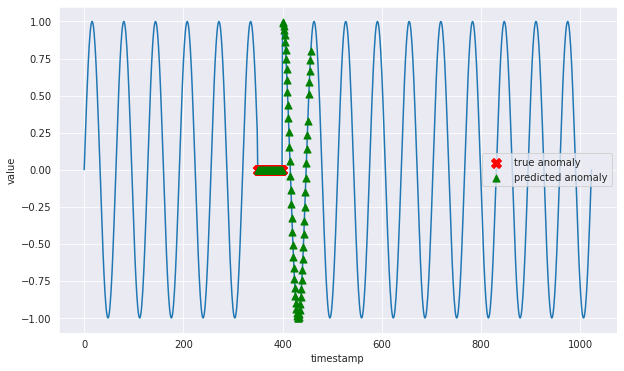

In [6]:
model.train_detector(train_loader)
true_anomalies, pred_anomalies = model.evaluate_detector(test_loader)
pipeline.plot_with_anomalies(df, np.where(true_anomalies > 0)[0], np.where(pred_anomalies > 0)[0], window=window)

In [7]:
loss_sum = 0
y_preds = None
for tmp_x, tmp_y, tmp_anomalies in test_loader:
    y_pred = model(tmp_x)[:, 0].cpu().detach().numpy()
    if y_preds is None:
        y_preds = y_pred
    else:
        y_preds = np.concatenate([y_preds, y_pred])

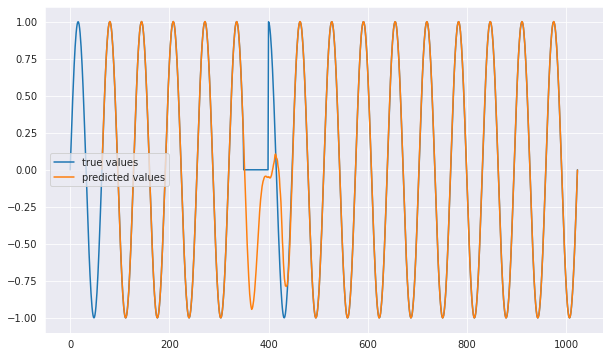

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df.index, df["value"], label="true values")
ax.plot(df.index[window:len(y_preds)+window], y_preds, label="predicted values")
ax.legend();

In [12]:
#!rm -rf ./logs/DeepAnt